In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as tt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize((0.5,), (1.0,))
])

In [3]:
data = datasets.MNIST(root = './data' , train=True, transform=transform, download=False)
data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True, num_workers=10)

In [4]:
dataiter = iter(data_loader)
images, labels = dataiter.next()

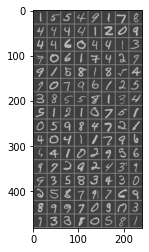

In [5]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

In [6]:
print(labels)

tensor([1, 5, 5, 4, 9, 1, 7, 8, 4, 4, 4, 4, 1, 2, 0, 9, 4, 4, 6, 0, 4, 4, 1, 3,
        7, 0, 6, 1, 7, 4, 2, 9, 9, 1, 5, 8, 1, 8, 5, 4, 7, 0, 7, 9, 6, 1, 2, 5,
        3, 8, 5, 5, 8, 1, 3, 4, 5, 1, 2, 1, 0, 7, 5, 1, 0, 5, 9, 8, 4, 7, 2, 1,
        4, 0, 4, 1, 1, 7, 9, 6, 5, 4, 1, 0, 2, 9, 5, 6, 9, 7, 2, 9, 2, 4, 3, 9,
        9, 3, 5, 8, 3, 4, 3, 0, 2, 5, 8, 7, 9, 7, 6, 9, 8, 9, 9, 7, 0, 9, 0, 3,
        9, 3, 3, 8, 0, 5, 8, 1])


In [7]:
class Discriminator(nn.Module):
    
     def __init__(self):
        super().__init__()
        self.input_size = (1,28,28)
        self.num_classes = 10
        
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        
        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
     def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)
        x = self.dis(dis_input)
        return x

In [8]:
# # Creating the discriminator model ( Goal: Discriminate wether an image is real or not )
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
        
#         self.input_size = (1,28,28)
#         self.num_classes = 10
        
#         self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        
#         self.conv1 = nn.Conv2d(11, 64, kernel_size=(3,3), stride=(2,2), padding=1, bias=False)
#         self.LeakyReLU = nn.LeakyReLU(0.2)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=(2,2), padding=1, bias=False)

#         self.linear = nn.Linear(7*7*64, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, img, labels):
#         dis_input = torch.cat((img,self.label_embedding(labels).view(labels.size(0),-1)),1)
#         x = self.conv1(dis_input)
#         x = self.LeakyReLU(x)
#         x = self.conv2(x)
#         x = self.LeakyReLU(x)
#         x = torch.flatten(x, 1)
#         x = self.linear(x)
#         x = self.sigmoid(x)
#         return x

In [9]:
x = torch.randn(128,1,28,28,device=device)
label = torch.randint(0,10,(128,), device=device)
model_dis = Discriminator().to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([128, 1])


In [10]:
model_dis

Discriminator(
  (label_embedding): Embedding(10, 10)
  (dis): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [11]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.num_classes = 10
        self.nz = 100 # 노이즈 수
        self.input_size = (1,28,28)
        
        # Noise와 label을 결합하는 용도인 label embedding matrix를 생성
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)
        
        self.n_dim = 7 * 7 * 128 
        
        # Generator
        # here we use a hardcoded value of dimnsionality for our latent z vector ( 100 )
        self.fc1 = nn.Linear(self.nz+self.num_classes, 128 * 7 * 7 )
        self.convTranspose1 = nn.ConvTranspose2d(128, 128, kernel_size=(4,4), stride = (2,2), padding=0)
        self.leaky = nn.LeakyReLU(0.2)
        self.conv2d = nn.Conv2d(128, 1, kernel_size = (7,7), stride = (1,1), padding = 0)
    
        
    def forward(self, noise, labels):
        # noise와 label의 결합
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.fc1(gen_input)
        x = self.leaky(x)
        x = x.view(-1,128 ,7,7)
        x = self.convTranspose1(x)
        x = self.leaky(x)
        x = self.convTranspose1(x)
        x = self.leaky(x)
        x = self.conv2d(x)
        x = torch.tanh(x)
        #x = x.view(x.size(0), *self.input_size)
        return x

In [12]:
# # Creating the generator model ( Goal: generate fake images )
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.n_dim = 7 * 7 * 128 
#         # here we use a hardcoded value of dimnsionality for our latent z vector ( 100 )
#         self.fc1 = nn.Linear(100, 128 * 7 * 7 )
#         self.convTranspose1 = nn.ConvTranspose2d(128, 128, kernel_size=(4,4), stride = (2,2), padding=0)
#         self.leaky = nn.LeakyReLU(0.2)
#         self.conv2d = nn.Conv2d(128, 1, kernel_size = (7,7), stride = (1,1), padding = 0)
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.leaky(x)
#         x = x.view(-1,128 ,7,7)
#         x = self.convTranspose1(x)
#         x = self.leaky(x)
#         x = self.convTranspose1(x)
#         x = self.leaky(x)
#         x = self.conv2d(x)
#         x = torch.tanh(x)
#         return x

In [13]:
# class Generator(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.num_classes = 10
#         self.nz = 100 # 노이즈 수
#         self.input_size = (1,28,28)
        
#         # Noise와 label을 결합하는 용도인 label embedding matrix를 생성
#         self.label_emb = nn.Embedding(self.num_classes, self.num_classes)
        
#         # Generator
#         self.gen = nn.Sequential(
#             nn.Linear(self.nz + self.num_classes, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 256),
#             nn.BatchNorm1d(256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256,512),
#             nn.BatchNorm1d(512),
#             nn.LeakyReLU(0.2),
#             nn.Linear(512,1024),
#             nn.BatchNorm1d(1024),
#             nn.LeakyReLU(0.2),
#             nn.Linear(1024,int(np.prod(self.input_size))),
#             nn.Tanh()
#         )
        
#     def forward(self, noise, labels):
#         # noise와 label의 결합
#         label_emb = self.label_emb(labels)  # label embedding을 확장
#         gen_input = torch.cat((label_emb, noise), dim=-1)  # 결합
#         x = self.gen(gen_input)
#         x = x.view(x.size(0), *self.input_size)
#         return x


In [14]:
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator().to(device)
out_gen = model_gen(x,label)
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


In [15]:
# def initialize_weights(model):
#     classname = model.__class__.__name__
#     # fc layer
#     if classname.find('Linear') != -1:
#         nn.init.normal_(model.weight.data, 0.0, 0.02)
#         nn.init.constant_(model.bias.data, 0)
#     # batchnorm
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(model.weight.data, 1.0, 0.02)
#         nn.init.constant_(model.bias.data, 0)

In [16]:
# model_gen.apply(initialize_weights)

In [17]:
# model_dis.apply(initialize_weights)

In [18]:
# G = Generator()
# D = Discriminator()
# #Sanity check of the model instances
# print(D)
# print(G)

# #Passing to the GPU
# D = D.to(device)
# G = G.to(device)
# D = D.float()
# G = G.float()

In [19]:
from tqdm import tqdm
import torch.optim as optim

disc_opt = optim.Adam(model_dis.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(model_gen.parameters(), lr = 0.0002, betas = (0.5, 0.999))

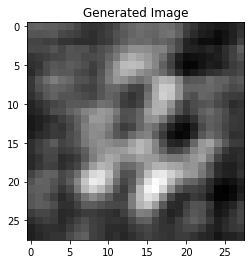

Epoch  1 : Discriminator Loss =  0.0011043328720369318 , Generator Loss =  0.002396504253720932


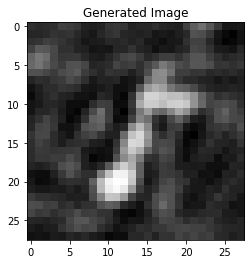

Epoch  2 : Discriminator Loss =  0.0013123468549520985 , Generator Loss =  0.0021521620658923315


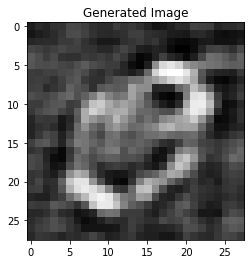

Epoch  3 : Discriminator Loss =  0.0013682265271510142 , Generator Loss =  0.002442636469533957


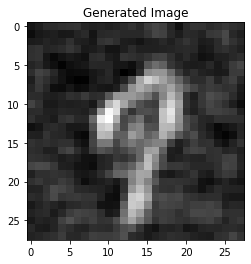

Epoch  4 : Discriminator Loss =  0.0013730984761008323 , Generator Loss =  0.00251437606079492


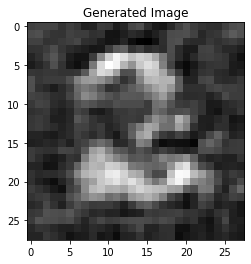

Epoch  5 : Discriminator Loss =  0.0014067538765701912 , Generator Loss =  0.00230423423018791


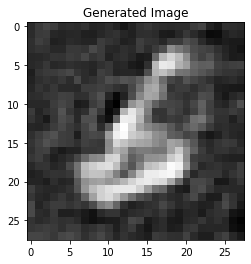

Epoch  6 : Discriminator Loss =  0.0014308729151418724 , Generator Loss =  0.002097910019888807


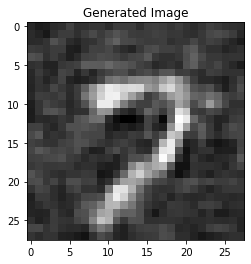

Epoch  7 : Discriminator Loss =  0.0013226522311472943 , Generator Loss =  0.0021838160720207035


KeyboardInterrupt: 

In [20]:
model_dis.train()
model_gen.train()

disc_losses = []
gen_losses = []

loss_history={'gen':[],
              'dis':[]}

criterion = nn.BCELoss()

for epoch in range(100):
    for xb, yb in data_loader:
        ba_si = xb.shape[0]
        
        xb = xb.to(device)
        yb = yb.to(device)
        
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device) # fake_label

        # Discriminator
        model_dis.zero_grad()
        
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        #noise = torch.randn(ba_si, 1, 1, 100).to(device) # 노이즈 생성

        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

         # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)
        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = criterion(out_dis, yb_real)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label)
        loss_fake = criterion(out_dis,yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        disc_opt.step()
        
        # Genetator
        model_gen.zero_grad()

         # 가짜 이미지 생성
        output = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(output, gen_label)

        loss_gen = criterion(out_dis, yb_real)
        loss_gen.backward()
        gen_opt.step()

        disc_losses.append(loss_dis)
        gen_losses.append(loss_gen)
        
        torch.save(model_gen.state_dict(), './gen2.pt')
        torch.save(model_dis.state_dict(), './dis2.pt')
        
    model_gen.eval()  # Going into eval mode to get sample images
    fixed_noise = torch.randn(16, 100, device=device)
    label = torch.randint(0,10,(16,), device=device)
    samples = model_gen(fixed_noise, label)
    #model_gen.train()  # Going back into train mode

    plt.imshow(samples[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    plt.title("Generated Image")
    plt.show() 


    print("Epoch ", epoch+1, ": Discriminator Loss = ", loss_dis.item()/len(data_loader), ", Generator Loss = ", loss_gen.item()/len(data_loader))

In [ ]:
# fixed_samples = random_noise_generator(sample_size, gen_input_size)
# fixed_samples = fixed_samples.to(device)

# G.eval()  # Going into eval mode to get sample images         
# samples = G(fixed_samples.float())
# G.train()  # Going back into train mode

# plt.imshow(samples[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
# plt.title("Generated Image")
# plt.show()

In [ ]:
disc_losses_cpu = [loss.cpu().item() for loss in disc_losses]
gen_losses_cpu = [loss.cpu().item() for loss in gen_losses]

plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(disc_losses_cpu, label='Dis. Loss')
plt.plot(gen_losses_cpu, label='Gen. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # Generator의 가중치 저장
# torch.save(model_gen.state_dict(), 'generator_weights.pth')
# torch.save(model_dis.state_dict(), 'discriminator_weights.pth')

In [ ]:
# import os
# path2models = '.'
# os.makedirs(path2models, exist_ok=True)
# path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
# path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

# torch.save(model_gen.state_dict(), path2weights_gen)
# torch.save(model_dis.state_dict(), path2weights_dis)

In [ ]:
model_gen.load_state_dict(torch.load('./gen2.pt'))
# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fig = plt.figure(figsize=(12, 20))
    rows, cols = 10, 5  # 10개의 행, 각 행당 5개의 열
    for i in range(10):
        for j in range(5):
            fixed_noise = torch.randn(16, 100, device=device)
            label = torch.tensor([i] * 16, device=device)  # 각 행에 해당하는 레이블
            img_fake = model_gen(fixed_noise, label).detach().cpu()
            fig.add_subplot(rows, cols, i*5 + j + 1)
            plt.title(label[0].item())  # 레이블의 첫 번째 요소를 사용하여 이미지에 제목 표시
            plt.imshow(img_fake[0].squeeze(), cmap='gray')  # 첫 번째 이미지만 표시
plt.show()
